<a href="https://colab.research.google.com/github/bahar2025-AI/Housing-Price-Prediction-Model/blob/main/Housing_Price_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Enhanced Multivariate Regression Analysis
# Based on original code from "Mastering ML with Python in Six Steps"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
import warnings
import time
import joblib


In [2]:

# Set aesthetic parameters for better visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)
warnings.filterwarnings('ignore')

# Custom color palette
colors_palette = sns.color_palette("viridis", 8)
sns.set_palette(colors_palette)

# Function to load and prepare data
def load_housing_data():
    """Load the Boston Housing dataset"""
    from sklearn.datasets import fetch_california_housing

    # Load California Housing dataset (a more modern alternative to Boston Housing)
    housing = fetch_california_housing()

    # Create a DataFrame
    features = pd.DataFrame(housing.data, columns=housing.feature_names)
    target = pd.Series(housing.target, name="MEDV")

    print(f"Dataset shape: {features.shape}")
    print(f"Features: {', '.join(features.columns)}")

    return features, target

# Load data
X, y = load_housing_data()

Dataset shape: (20640, 8)
Features: MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude


In [7]:

# Exploratory Data Analysis
def perform_eda(X, y):
    """Perform enhanced exploratory data analysis with visualizations"""
    # Combining features and target for analysis
    data = pd.concat([X, y], axis=1)

    # Summary statistics
    print("Summary Statistics:")
    summary = data.describe().T
    summary["skew"] = data.skew()
    print(summary)
data = perform_eda(X, y)

Summary Statistics:
              count         mean          std         min         25%  \
MedInc      20640.0     3.870671     1.899822    0.499900    2.563400   
HouseAge    20640.0    28.639486    12.585558    1.000000   18.000000   
AveRooms    20640.0     5.429000     2.474173    0.846154    4.440716   
AveBedrms   20640.0     1.096675     0.473911    0.333333    1.006079   
Population  20640.0  1425.476744  1132.462122    3.000000  787.000000   
AveOccup    20640.0     3.070655    10.386050    0.692308    2.429741   
Latitude    20640.0    35.631861     2.135952   32.540000   33.930000   
Longitude   20640.0  -119.569704     2.003532 -124.350000 -121.800000   
MEDV        20640.0     2.068558     1.153956    0.149990    1.196000   

                    50%          75%           max       skew  
MedInc         3.534800     4.743250     15.000100   1.646657  
HouseAge      29.000000    37.000000     52.000000   0.060331  
AveRooms       5.229129     6.052381    141.909091  20.69

In [12]:
# Exploratory Data Analysis
def perform_eda(X, y):
    """Perform enhanced exploratory data analysis with visualizations"""
    # Combining features and target for analysis
    data = pd.concat([X, y], axis=1)

    # Summary statistics
    print("Summary Statistics:")
    summary = data.describe().T
    summary["skew"] = data.skew()
    print(summary)

    # Create figure for histograms
    plt.figure(figsize=(15, 10))
    for i, column in enumerate(data.columns):
        plt.subplot(3, 4, i+1)
        sns.histplot(data[column], kde=True, color=colors_palette[i % len(colors_palette)])
        plt.title(f'Distribution of {column}')
        plt.tight_layout()
    plt.savefig('feature_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()  # اضافه کردن این خط برای نمایش نمودار

    # Correlation matrix with enhanced heatmap
    plt.figure(figsize=(12, 10))
    corr = data.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, annot=True, fmt=".2f", cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix', fontsize=16)
    plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()  # اضافه کردن این خط برای نمایش نمودار

    # Pairplot for key features (select a subset to avoid overcrowding)
    # Find top correlated features with target
    corr_with_target = abs(corr[y.name]).sort_values(ascending=False)
    top_features = corr_with_target[1:5].index.tolist()  # Exclude target itself

    plt.figure(figsize=(12, 10))
    subset_data = data[[y.name] + top_features]
    sns.pairplot(subset_data, height=2.5, diag_kind='kde',
                plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'k', 'linewidth': 0.5})
    plt.savefig('pairplot.png', dpi=300, bbox_inches='tight')
    plt.show()  # اضافه کردن این خط برای نمایش نمودار

    # 3D plot of top 2 features with target
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    x_feat, y_feat = top_features[0], top_features[1]

    scatter = ax.scatter(data[x_feat],
                        data[y_feat],
                        data[y.name],
                        c=data[y.name],
                        cmap='viridis',
                        s=50,
                        alpha=0.7,
                        edgecolor='w',
                        linewidth=0.5)

    ax.set_xlabel(x_feat, fontsize=12)
    ax.set_ylabel(y_feat, fontsize=12)
    ax.set_zlabel(y.name, fontsize=12)
    ax.set_title(f'3D Relationship between {x_feat}, {y_feat} and {y.name}', fontsize=14)
    plt.colorbar(scatter, ax=ax, shrink=0.6, aspect=20, label=y.name)

    # Adjust the view angle for better visualization
    ax.view_init(elev=30, azim=45)
    plt.savefig('3d_plot.png', dpi=300, bbox_inches='tight')
    plt.show()  # اضافه کردن این خط برای نمایش نمودار

    return data

In [13]:

# Feature Engineering
def perform_feature_engineering(X, y):
    """Enhanced feature engineering with visualization"""
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Create polynomial features
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X_scaled)

    # Get feature names for polynomials
    poly_features = poly.get_feature_names_out(input_features=X.columns)
    X_poly_df = pd.DataFrame(X_poly, columns=poly_features)

    print(f"Original features: {X.shape[1]}")
    print(f"Polynomial features: {X_poly.shape[1]}")

    # PCA for visualization and dimensionality reduction
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Visualize PCA results
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis',
               alpha=0.7, s=70, edgecolor='w', linewidth=0.5)
    plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title('PCA of Housing Features')
    plt.colorbar(scatter, label='Housing Price')
    plt.grid(alpha=0.3)
    plt.savefig('pca_visualization.png', dpi=300, bbox_inches='tight')
    plt.close()

    # Return both original scaled and polynomial features
    return X_scaled, X_poly, pca


Enhanced Multivariate Regression Analysis
Dataset shape: (20640, 8)
Features: MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude

1. Performing Exploratory Data Analysis
--------------------------------------------------
Summary Statistics:
              count         mean          std         min         25%  \
MedInc      20640.0     3.870671     1.899822    0.499900    2.563400   
HouseAge    20640.0    28.639486    12.585558    1.000000   18.000000   
AveRooms    20640.0     5.429000     2.474173    0.846154    4.440716   
AveBedrms   20640.0     1.096675     0.473911    0.333333    1.006079   
Population  20640.0  1425.476744  1132.462122    3.000000  787.000000   
AveOccup    20640.0     3.070655    10.386050    0.692308    2.429741   
Latitude    20640.0    35.631861     2.135952   32.540000   33.930000   
Longitude   20640.0  -119.569704     2.003532 -124.350000 -121.800000   
MEDV        20640.0     2.068558     1.153956    0.149990    1.196000   

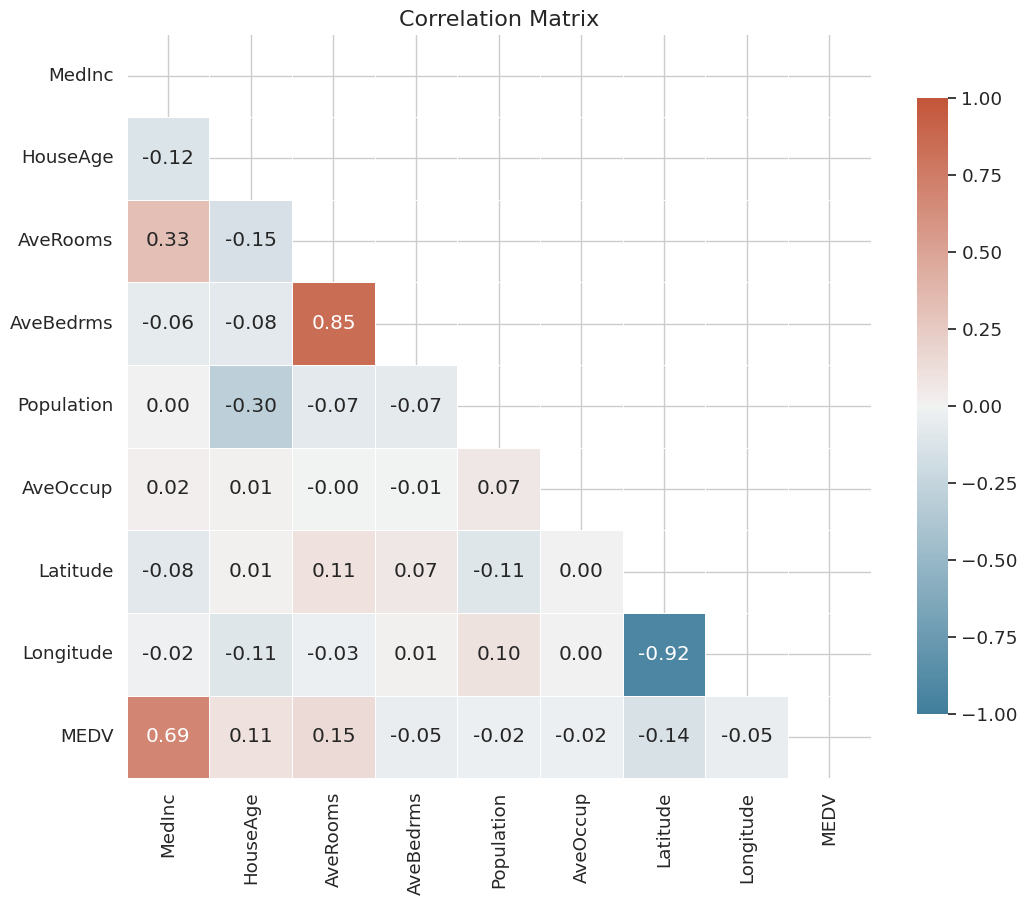


2. Performing Feature Engineering
--------------------------------------------------
Original features: 8
Polynomial features: 44


<Figure size 1200x1000 with 0 Axes>

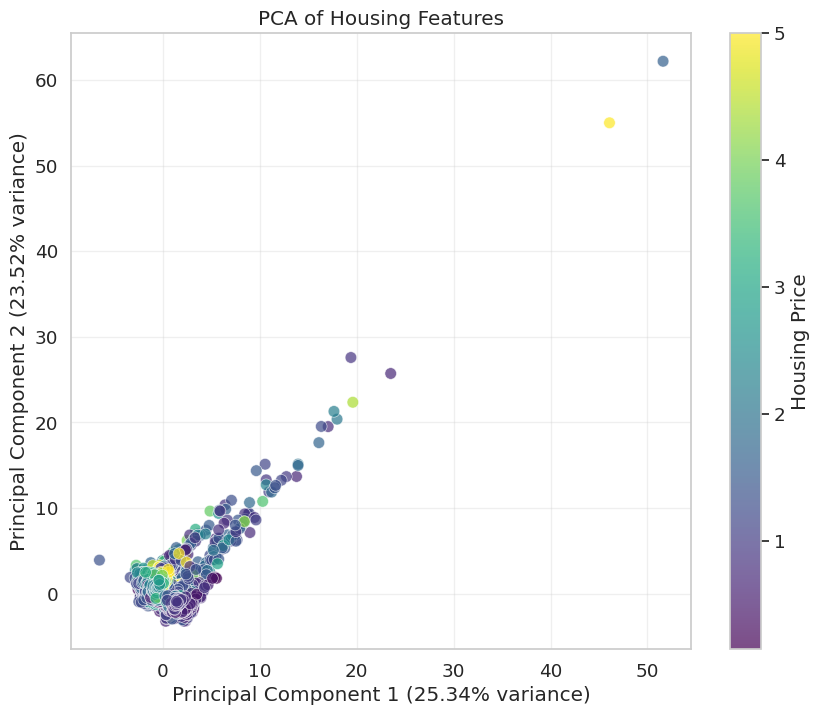


3. Training and Evaluating Models
--------------------------------------------------


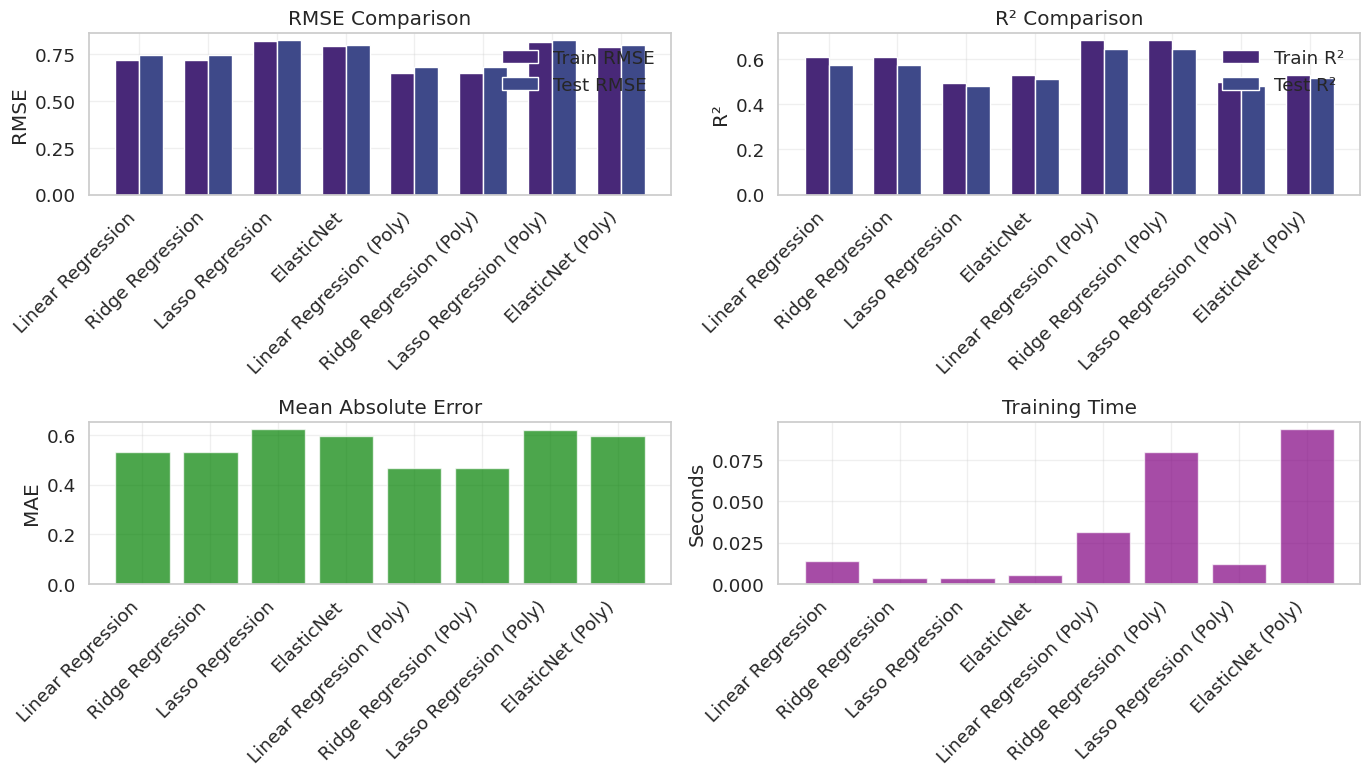


Model Comparison:
                    Name  Train RMSE  Test RMSE  Train R²  Test R²      MAE  CV R² (mean)  CV R² (std)  Training Time (s)
       Linear Regression    0.719676   0.745581  0.612551 0.575788 0.533200      0.553031     0.061692           0.013931
        Ridge Regression    0.719676   0.745554  0.612551 0.575819 0.533193      0.553038     0.061703           0.003439
        Lasso Regression    0.819606   0.824349  0.497483 0.481420 0.622148      0.431008     0.073869           0.003515
              ElasticNet    0.791935   0.797346  0.530841 0.514838 0.596967      0.456633     0.067848           0.005073
Linear Regression (Poly)    0.648634   0.681397  0.685268 0.645682 0.467001    -25.129225    51.115275           0.031381
 Ridge Regression (Poly)    0.648637   0.680023  0.685265 0.647109 0.467021    -16.113771    33.103367           0.079811
 Lasso Regression (Poly)    0.816571   0.823487  0.501198 0.482504 0.619658      0.434319     0.072511           0.011910
     

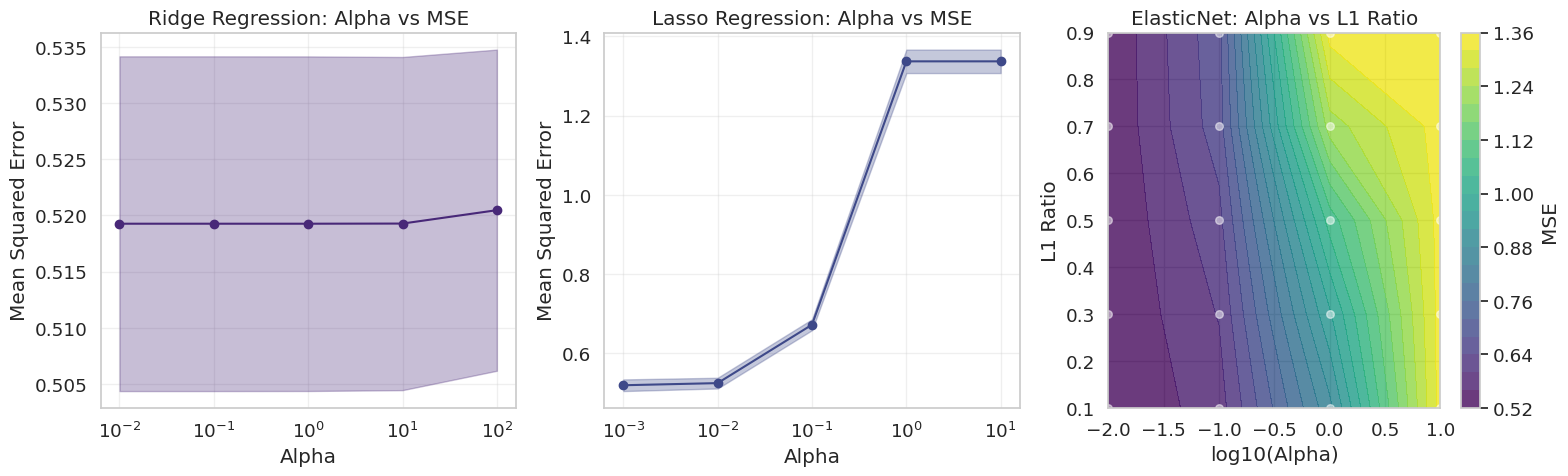


5. Residual Analysis
--------------------------------------------------


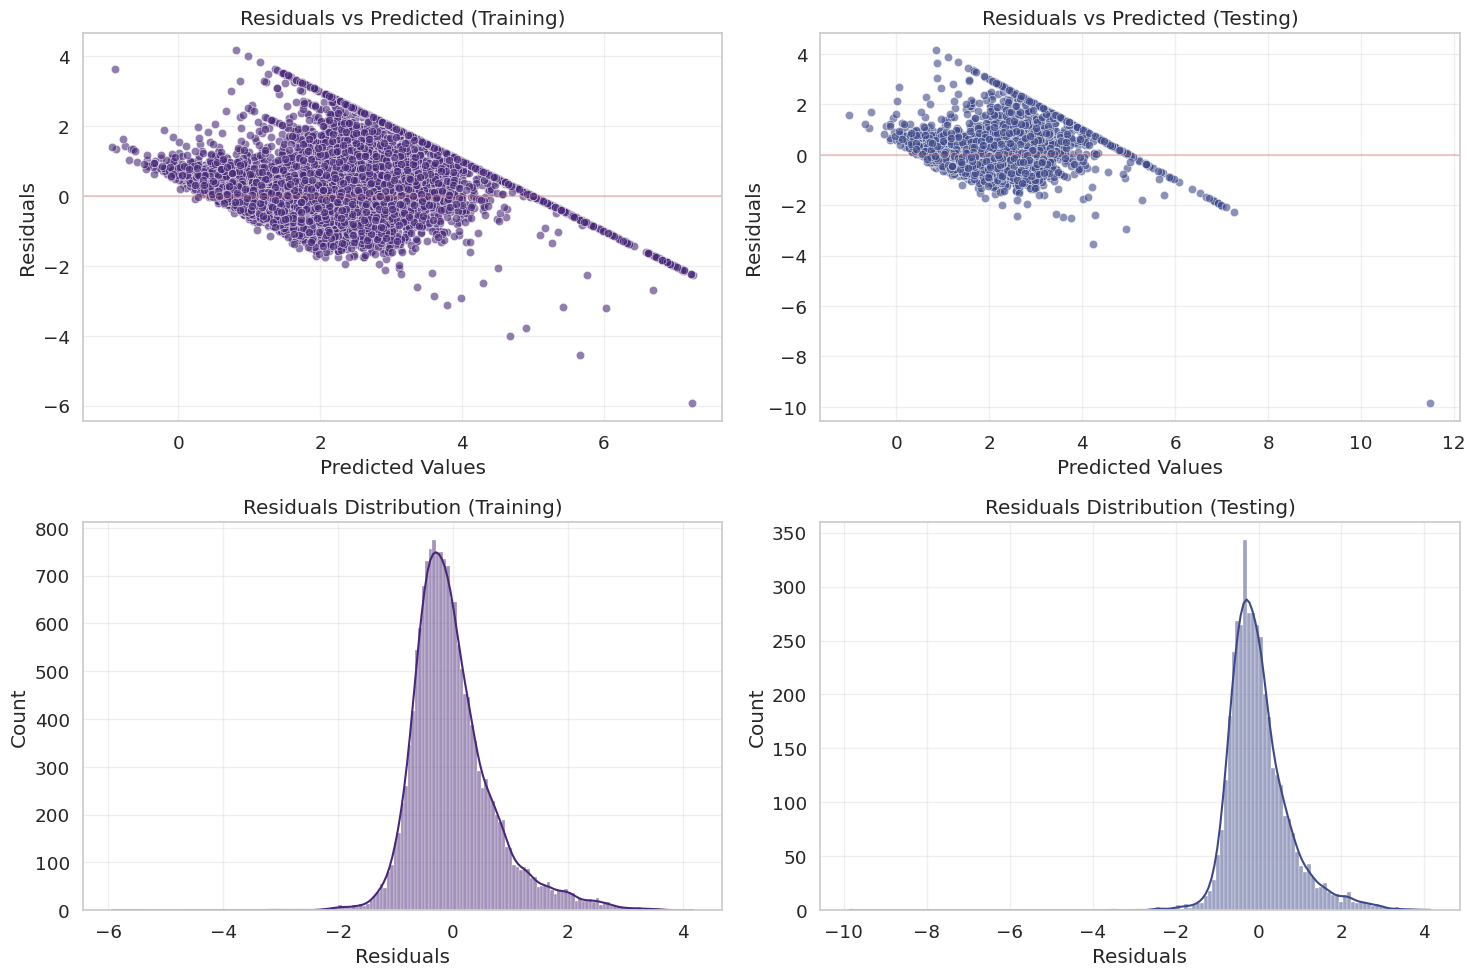

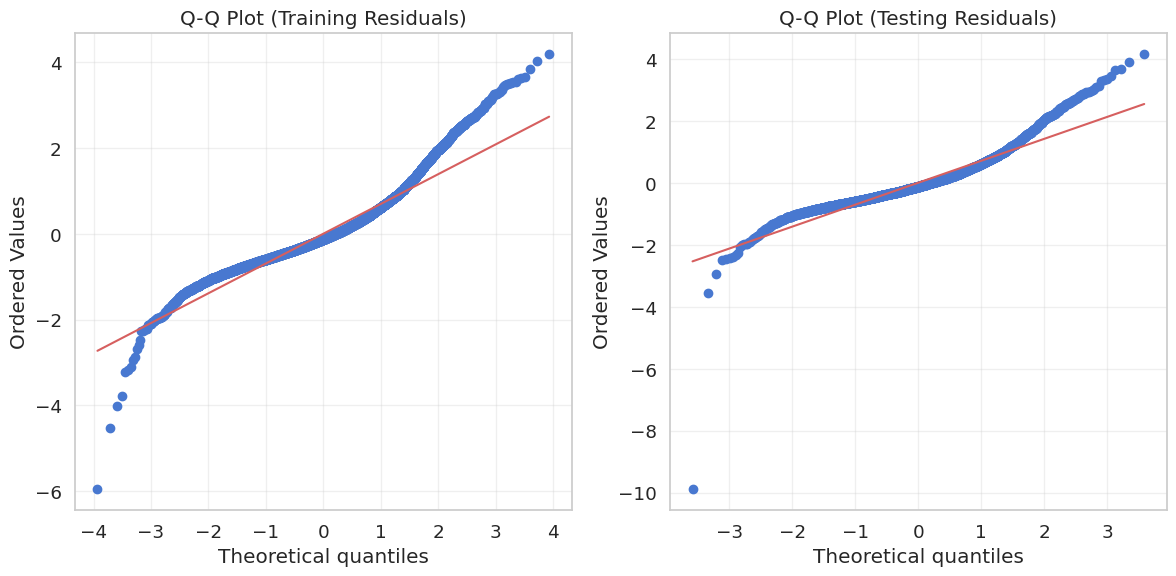

Training MSE: 0.5179
Testing MSE: 0.5559
Training R²: 0.6126
Testing R²: 0.5758


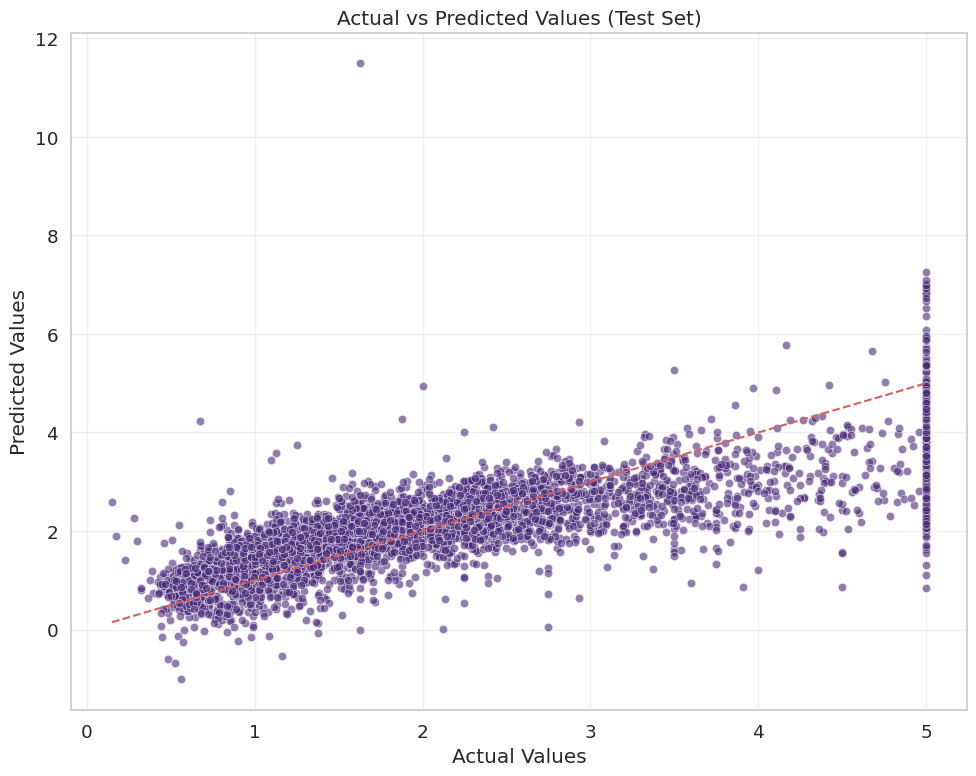


6. Feature Importance Analysis
--------------------------------------------------


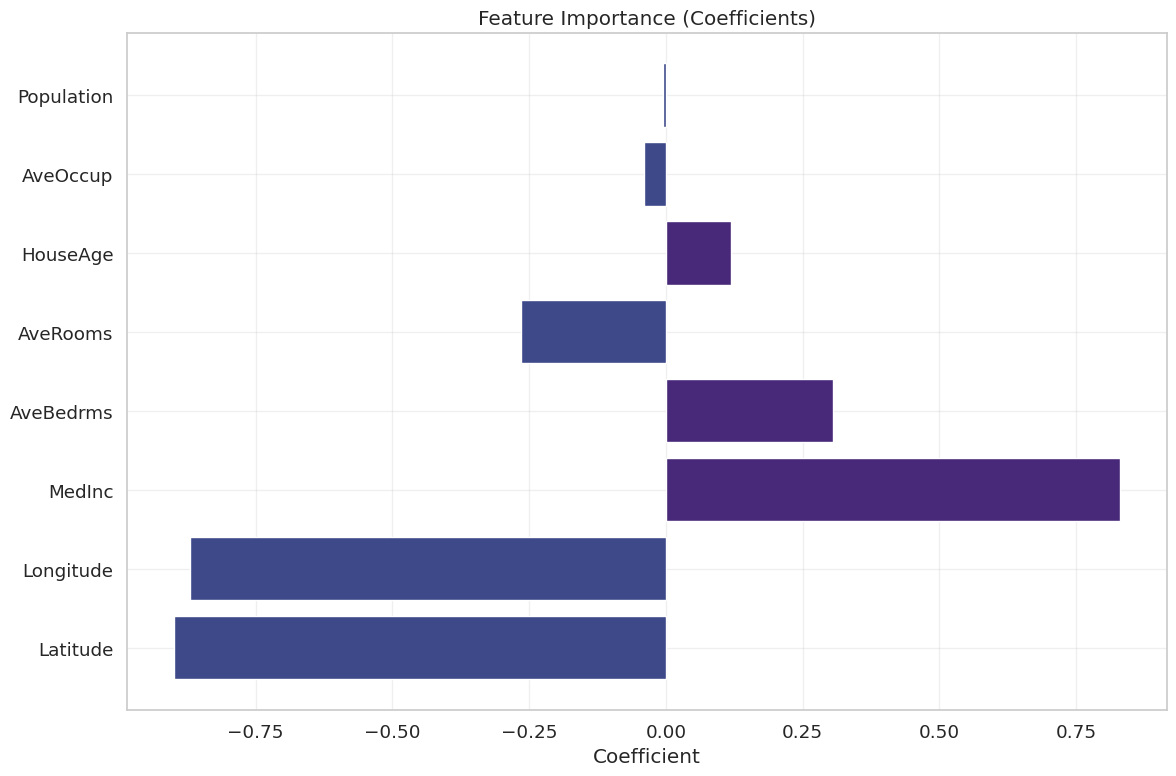


Feature Importance:
   Feature  Coefficient  Abs_Coefficient
  Latitude    -0.899266         0.899266
 Longitude    -0.869916         0.869916
    MedInc     0.829593         0.829593
 AveBedrms     0.305525         0.305525
  AveRooms    -0.265397         0.265397
  HouseAge     0.118817         0.118817
  AveOccup    -0.039330         0.039330
Population    -0.004480         0.004480
Model saved as best_housing_model.pkl

Analysis complete! All visualizations have been saved.


In [16]:
# Feature Engineering
def perform_feature_engineering(X, y):
    """Enhanced feature engineering with visualization"""
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Create polynomial features
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X_scaled)

    # Get feature names for polynomials
    poly_features = poly.get_feature_names_out(input_features=X.columns)
    X_poly_df = pd.DataFrame(X_poly, columns=poly_features)

    print(f"Original features: {X.shape[1]}")
    print(f"Polynomial features: {X_poly.shape[1]}")

    # PCA for visualization and dimensionality reduction
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Visualize PCA results
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis',
               alpha=0.7, s=70, edgecolor='w', linewidth=0.5)
    plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title('PCA of Housing Features')
    plt.colorbar(scatter, label='Housing Price')
    plt.grid(alpha=0.3)
    plt.savefig('pca_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()  # اضافه کردن این خط برای نمایش نمودار

    # Return both original scaled and polynomial features
    return X_scaled, X_poly, pca

# Model Training and Evaluation
def train_and_evaluate_models(X, y, X_poly=None):
    """Train multiple regression models with enhanced evaluation"""
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if X_poly is not None:
        X_poly_train, X_poly_test, _, _ = train_test_split(X_poly, y, test_size=0.2, random_state=42)

    # Models to evaluate
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.1),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5)
    }

    results = []

    # Standard features models
    for name, model in models.items():
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time

        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # Evaluation metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        mae = mean_absolute_error(y_test, y_pred_test)

        # Cross-validation
        cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')

        results.append({
            'Name': f"{name}",
            'Train RMSE': train_rmse,
            'Test RMSE': test_rmse,
            'Train R²': train_r2,
            'Test R²': test_r2,
            'MAE': mae,
            'CV R² (mean)': cv_scores.mean(),
            'CV R² (std)': cv_scores.std(),
            'Training Time (s)': train_time
        })

    # Polynomial features models
    if X_poly is not None:
        for name, model in models.items():
            start_time = time.time()
            model.fit(X_poly_train, y_train)
            train_time = time.time() - start_time

            # Predictions
            y_pred_train = model.predict(X_poly_train)
            y_pred_test = model.predict(X_poly_test)

            # Evaluation metrics
            train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
            test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
            train_r2 = r2_score(y_train, y_pred_train)
            test_r2 = r2_score(y_test, y_pred_test)
            mae = mean_absolute_error(y_test, y_pred_test)

            # Cross-validation
            cv_scores = cross_val_score(model, X_poly, y, cv=5, scoring='r2')

            results.append({
                'Name': f"{name} (Poly)",
                'Train RMSE': train_rmse,
                'Test RMSE': test_rmse,
                'Train R²': train_r2,
                'Test R²': test_r2,
                'MAE': mae,
                'CV R² (mean)': cv_scores.mean(),
                'CV R² (std)': cv_scores.std(),
                'Training Time (s)': train_time
            })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Visualize model comparison
    plt.figure(figsize=(14, 8))

    # RMSE Comparison
    plt.subplot(2, 2, 1)
    barwidth = 0.35
    x = np.arange(len(results_df['Name']))
    plt.bar(x - barwidth/2, results_df['Train RMSE'], barwidth, label='Train RMSE')
    plt.bar(x + barwidth/2, results_df['Test RMSE'], barwidth, label='Test RMSE')
    plt.xticks(x, results_df['Name'], rotation=45, ha='right')
    plt.ylabel('RMSE')
    plt.title('RMSE Comparison')
    plt.legend()
    plt.grid(alpha=0.3)

    # R² Comparison
    plt.subplot(2, 2, 2)
    plt.bar(x - barwidth/2, results_df['Train R²'], barwidth, label='Train R²')
    plt.bar(x + barwidth/2, results_df['Test R²'], barwidth, label='Test R²')
    plt.xticks(x, results_df['Name'], rotation=45, ha='right')
    plt.ylabel('R²')
    plt.title('R² Comparison')
    plt.legend()
    plt.grid(alpha=0.3)

    # MAE
    plt.subplot(2, 2, 3)
    plt.bar(x, results_df['MAE'], color='green', alpha=0.7)
    plt.xticks(x, results_df['Name'], rotation=45, ha='right')
    plt.ylabel('MAE')
    plt.title('Mean Absolute Error')
    plt.grid(alpha=0.3)

    # Training Time
    plt.subplot(2, 2, 4)
    plt.bar(x, results_df['Training Time (s)'], color='purple', alpha=0.7)
    plt.xticks(x, results_df['Name'], rotation=45, ha='right')
    plt.ylabel('Seconds')
    plt.title('Training Time')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()  # اضافه کردن این خط برای نمایش نمودار

    return results_df

# Hyperparameter Tuning
def tune_hyperparameters(X, y):
    """Perform hyperparameter tuning with visualization"""
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define parameter grids
    param_grids = {
        'ridge': {
            'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
        },
        'lasso': {
            'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
        },
        'elasticnet': {
            'alpha': [0.01, 0.1, 1.0, 10.0],
            'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
        }
    }

    # Models
    models = {
        'ridge': Ridge(),
        'lasso': Lasso(),
        'elasticnet': ElasticNet()
    }

    # Store best models
    best_models = {}
    cv_results = {}

    # Tuning
    for name, model in models.items():
        grid = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error')
        grid.fit(X_train, y_train)

        # Store best model
        best_models[name] = grid.best_estimator_
        cv_results[name] = grid.cv_results_

        print(f"{name.capitalize()} best parameters: {grid.best_params_}")
        print(f"{name.capitalize()} best score: {-grid.best_score_:.4f} (MSE)")

    # Visualize hyperparameter tuning results
    # Ridge alpha vs MSE
    plt.figure(figsize=(16, 5))

    plt.subplot(1, 3, 1)
    alphas = param_grids['ridge']['alpha']
    mean_scores = -cv_results['ridge']['mean_test_score']
    std_scores = cv_results['ridge']['std_test_score']

    plt.semilogx(alphas, mean_scores, marker='o', linestyle='-', color=colors_palette[0])
    plt.fill_between(alphas, mean_scores - std_scores, mean_scores + std_scores, alpha=0.3, color=colors_palette[0])
    plt.xlabel('Alpha')
    plt.ylabel('Mean Squared Error')
    plt.title('Ridge Regression: Alpha vs MSE')
    plt.grid(alpha=0.3)

    # Lasso alpha vs MSE
    plt.subplot(1, 3, 2)
    alphas = param_grids['lasso']['alpha']
    mean_scores = -cv_results['lasso']['mean_test_score']
    std_scores = cv_results['lasso']['std_test_score']

    plt.semilogx(alphas, mean_scores, marker='o', linestyle='-', color=colors_palette[1])
    plt.fill_between(alphas, mean_scores - std_scores, mean_scores + std_scores, alpha=0.3, color=colors_palette[1])
    plt.xlabel('Alpha')
    plt.ylabel('Mean Squared Error')
    plt.title('Lasso Regression: Alpha vs MSE')
    plt.grid(alpha=0.3)

    # ElasticNet contour plot
    plt.subplot(1, 3, 3)
    results = pd.DataFrame(cv_results['elasticnet'])
    alphas = np.array(param_grids['elasticnet']['alpha'])
    l1_ratios = np.array(param_grids['elasticnet']['l1_ratio'])

    # Create a grid of alpha and l1_ratio values
    alpha_grid, l1_ratio_grid = np.meshgrid(alphas, l1_ratios)

    # Reshape the scores for contour plot
    scores = np.zeros_like(alpha_grid)
    for i, alpha in enumerate(alphas):
        for j, l1_ratio in enumerate(l1_ratios):
            mask = (results['param_alpha'] == alpha) & (results['param_l1_ratio'] == l1_ratio)
            scores[j, i] = -results.loc[mask, 'mean_test_score'].values[0]

    # Create contour plot
    contour = plt.contourf(np.log10(alpha_grid), l1_ratio_grid, scores, levels=20, cmap='viridis', alpha=0.8)
    plt.colorbar(contour, label='MSE')
    plt.scatter(np.log10(alpha_grid), l1_ratio_grid, color='white', s=30, alpha=0.5)
    plt.xlabel('log10(Alpha)')
    plt.ylabel('L1 Ratio')
    plt.title('ElasticNet: Alpha vs L1 Ratio')

    plt.tight_layout()
    plt.savefig('hyperparameter_tuning.png', dpi=300, bbox_inches='tight')
    plt.show()  # اضافه کردن این خط برای نمایش نمودار

    return best_models

# Analyze residuals
def analyze_residuals(X, y, model):
    """Analyze and visualize residuals"""
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit model
    model.fit(X_train, y_train)

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate residuals
    residuals_train = y_train - y_pred_train
    residuals_test = y_test - y_pred_test

    # Create figure for residuals analysis
    plt.figure(figsize=(15, 10))

    # Residuals vs Predicted (Training)
    plt.subplot(2, 2, 1)
    plt.scatter(y_pred_train, residuals_train, alpha=0.6, color=colors_palette[0], edgecolor='w', linewidth=0.5)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted (Training)')
    plt.grid(alpha=0.3)

    # Residuals vs Predicted (Testing)
    plt.subplot(2, 2, 2)
    plt.scatter(y_pred_test, residuals_test, alpha=0.6, color=colors_palette[1], edgecolor='w', linewidth=0.5)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted (Testing)')
    plt.grid(alpha=0.3)

    # Residuals histogram (Training)
    plt.subplot(2, 2, 3)
    sns.histplot(residuals_train, kde=True, color=colors_palette[0])
    plt.xlabel('Residuals')
    plt.title('Residuals Distribution (Training)')
    plt.grid(alpha=0.3)

    # Residuals histogram (Testing)
    plt.subplot(2, 2, 4)
    sns.histplot(residuals_test, kde=True, color=colors_palette[1])
    plt.xlabel('Residuals')
    plt.title('Residuals Distribution (Testing)')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('residuals_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()  # اضافه کردن این خط برای نمایش نمودار

    # QQ plot for normality check
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    from scipy import stats
    stats.probplot(residuals_train, dist="norm", plot=plt)
    plt.title('Q-Q Plot (Training Residuals)')
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    stats.probplot(residuals_test, dist="norm", plot=plt)
    plt.title('Q-Q Plot (Testing Residuals)')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('residuals_qq_plot.png', dpi=300, bbox_inches='tight')
    plt.show()  # اضافه کردن این خط برای نمایش نمودار

    # Calculate metrics
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    print(f"Training MSE: {mse_train:.4f}")
    print(f"Testing MSE: {mse_test:.4f}")
    print(f"Training R²: {r2_train:.4f}")
    print(f"Testing R²: {r2_test:.4f}")

    # Save predictions vs actual
    plt.figure(figsize=(10, 8))

    # Plot for test set
    plt.scatter(y_test, y_pred_test, alpha=0.6, color=colors_palette[0], edgecolor='w', linewidth=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values (Test Set)')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('actual_vs_predicted.png', dpi=300, bbox_inches='tight')
    plt.show()  # اضافه کردن این خط برای نمایش نمودار

# Feature Importance
def analyze_feature_importance(X, model):
    """Analyze and visualize feature importance"""
    # Get feature names
    feature_names = X.columns

    # Fit model
    model.fit(X, y)

    # Get coefficients
    if hasattr(model, 'coef_'):
        coefficients = model.coef_
    else:
        print("Model doesn't have coefficients attribute.")
        return

    # Create DataFrame
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

    # Sort by absolute value
    feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
    feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

    # Visualize
    plt.figure(figsize=(12, 8))

    # Bar plot of coefficients
    colors = [colors_palette[0] if c > 0 else colors_palette[1] for c in feature_importance['Coefficient']]
    plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors)
    plt.xlabel('Coefficient')
    plt.title('Feature Importance (Coefficients)')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()  # اضافه کردن این خط برای نمایش نمودار

    return feature_importance
# Save model
def save_best_model(model, filename='best_model.pkl'):
    """Save the best model to disk"""
    joblib.dump(model, filename)
    print(f"Model saved as {filename}")

# Main execution function
def main():
    """Main execution flow"""
    print("="*50)
    print("Enhanced Multivariate Regression Analysis")
    print("="*50)

    # Load data
    X, y = load_housing_data()

    # Exploratory Data Analysis
    print("\n1. Performing Exploratory Data Analysis")
    print("-"*50)
    data = perform_eda(X, y)

    # Feature Engineering
    print("\n2. Performing Feature Engineering")
    print("-"*50)
    X_scaled, X_poly, pca = perform_feature_engineering(X, y)

    # Model Training and Evaluation
    print("\n3. Training and Evaluating Models")
    print("-"*50)
    results = train_and_evaluate_models(X_scaled, y, X_poly)
    print("\nModel Comparison:")
    print(results.to_string(index=False))

    # Hyperparameter Tuning
    print("\n4. Hyperparameter Tuning")
    print("-"*50)
    best_models = tune_hyperparameters(X_scaled, y)

    # Select best model (Ridge in this case for demonstration)
    best_model = best_models['ridge']

    # Analyze Residuals
    print("\n5. Residual Analysis")
    print("-"*50)
    analyze_residuals(X_scaled, y, best_model)

    # Feature Importance
    print("\n6. Feature Importance Analysis")
    print("-"*50)
    X_df = pd.DataFrame(X_scaled, columns=X.columns)
    feature_importance = analyze_feature_importance(X_df, best_model)
    print("\nFeature Importance:")
    print(feature_importance.to_string(index=False))

    # Save best model
    save_best_model(best_model, 'best_housing_model.pkl')

    print("\nAnalysis complete! All visualizations have been saved.")

if __name__ == "__main__":
    main()